# Creative Use of VaR

## Lu Yicheng
## A0268497E

## 1. Preparation

For the dataset, we have a static portfolio wtih 200 AAPL, 1000 DAL and 1000 PFE.

First I download the three stocks’ information (including daily prices) from Yahoo finance for the period of 2017-01-01 to 2022-12-31 and use “ln(St+1/St)” as the daily returns (as we did in the first few tutorials). Adjusted close price is used when calculating returns.

First we import the packages needed.

In [1]:
#!usr/bin/env python
#-*- coding:utf-8 -*-
from __future__ import division
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from functools import reduce
from math import sqrt, exp
import datetime as dt
import yfinance as yf
from copy import deepcopy

%matplotlib inline

Define a helper function which loop through all the tickers and calculate log returns, then return the dictionary.

In [2]:
from pandas_datareader.data import DataReader

import requests_cache
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_data_for_multiple_stocks(tickers,start_date='2017-01-01',end_date= '2022-12-31'):  
    stocks = dict()
    
    for ticker in tickers: 
        format='%Y-%m-%d'
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))

        s.insert(0, "Ticker", ticker)  
        
        s['Prev Close'] = s['Adj Close'].shift(1)
        s['log_return'] = np.log(s['Adj Close']/s['Prev Close'])
        s['perc_return'] = (s['Adj Close']/s['Prev Close']) - 1
        stocks[ticker] = s
    return stocks

Now we obtain the data from yahoo finance and read that into the tickers using previous helper function

In [3]:
tickers = ['AAPL','DAL','PFE']
AAPL =  get_data_for_multiple_stocks(tickers,start_date='2017-01-01',end_date= '2022-12-31')['AAPL']
DAL =  get_data_for_multiple_stocks(tickers,start_date='2017-01-01',end_date= '2022-12-31')['DAL']
PFE =  get_data_for_multiple_stocks(tickers,start_date='2017-01-01',end_date= '2022-12-31')['PFE']

# Print for checking
AAPL.tail(n=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Ticker,Open,High,Low,Close,Adj Close,Volume,Prev Close,log_return,perc_return
Date,,,,,,,,,,
2022-12-23 00:00:00-05:00,AAPL,130.919998,132.419998,129.639999,131.860001,131.658981,63814900,132.028412,-0.002802,-0.002798
2022-12-27 00:00:00-05:00,AAPL,131.380005,131.410004,128.720001,130.029999,129.831772,69007800,131.658981,-0.013976,-0.013878
2022-12-28 00:00:00-05:00,AAPL,129.669998,131.029999,125.870003,126.040001,125.847855,85438400,129.831772,-0.031166,-0.030685
2022-12-29 00:00:00-05:00,AAPL,127.989998,130.479996,127.730003,129.610001,129.412415,75703700,125.847855,0.027931,0.028324
2022-12-30 00:00:00-05:00,AAPL,128.410004,129.949997,127.430000,129.929993,129.731918,76960600,129.412415,0.002466,0.002469


## Question 1

For this question I use Historical simulation approach to calculate the 𝛼 =1% daily VaR and 
ES of the percentage return of all three individual stocks and the portfolio. The sample period is 250 
trading days before your focal trading day of VaR, plot on the period 2018-01-01 to 2021-07-31. 
Plot and show the graph clearly, labelling your axes

First we transform Date from integer to date type so as to be able to access it as a pandas column rather than index

In [4]:
AAPL = AAPL.reset_index()
DAL= DAL.reset_index() 
PFE = PFE.reset_index() 
AAPL['Date'] = pd.to_datetime(AAPL['Date'], infer_datetime_format=True)
DAL['Date'] = pd.to_datetime(DAL['Date'], infer_datetime_format=True)
PFE['Date'] = pd.to_datetime(PFE['Date'], infer_datetime_format=True)

Now we define a Portfolio Manager(PM) as the portfolio.

In [5]:
PM = deepcopy(AAPL)

Assign the number of shares and values of the stocks and portfolio, as well as the previous values.

In [6]:
# Number of shares in our static portfolio
AAPL_share = 200
DAL_share = 1000
PFE_share = 1000

# Use Adjusted Close Price for return calculation
AAPL['PortValue'] = AAPL_share * AAPL['Adj Close']
DAL['PortValue'] = DAL_share * DAL['Adj Close']
PFE['PortValue'] = PFE_share * PFE['Adj Close']
PM['PortValue'] = AAPL['PortValue']+DAL['PortValue']+PFE['PortValue']

# And the price for the previous day
AAPL["Prev_PortValue"] = AAPL["PortValue"].shift(1)
DAL["Prev_PortValue"] = DAL["PortValue"].shift(1)
PFE["Prev_PortValue"] = PFE["PortValue"].shift(1)
PM["Prev_PortValue"] = PM["PortValue"].shift(1)

PM.loc[:,['Date','PortValue','Prev_PortValue']].head()

,Date,PortValue,Prev_PortValue
0,2017-01-03 00:00:00-05:00,76026.321793,NaN
1,2017-01-04 00:00:00-05:00,77366.106796,76026.321793
2,2017-01-05 00:00:00-05:00,76738.789749,77366.106796
3,2017-01-06 00:00:00-05:00,76655.298996,76738.789749
4,2017-01-09 00:00:00-05:00,76707.457733,76655.298996


Now we can calculate log return of the three stocks and the portfolio and get the corresponding dataframes.

In [7]:
AAPL["log_return"] = np.log(AAPL['PortValue']/AAPL["Prev_PortValue"])
DAL["log_return"] = np.log(DAL['PortValue']/DAL["Prev_PortValue"])
PFE["log_return"] = np.log(PFE['PortValue']/PFE["Prev_PortValue"])
PM["log_return"] = np.log(PM['PortValue']/PM["Prev_PortValue"])

df_aapl = AAPL.loc[:,['Date','PortValue','Prev_PortValue','log_return']]
df_dal = DAL.loc[:,['Date','PortValue','Prev_PortValue','log_return']]
df_pfe = PFE.loc[:,['Date','PortValue','Prev_PortValue','log_return']]
df_pm = PM.loc[:,['Date','PortValue','Prev_PortValue','log_return']]

# Print and check 
df_pm.head()

,Date,PortValue,Prev_PortValue,log_return
0,2017-01-03 00:00:00-05:00,76026.321793,NaN,NaN
1,2017-01-04 00:00:00-05:00,77366.106796,76026.321793,0.017469
2,2017-01-05 00:00:00-05:00,76738.789749,77366.106796,-0.008141
3,2017-01-06 00:00:00-05:00,76655.298996,76738.789749,-0.001089
4,2017-01-09 00:00:00-05:00,76707.457733,76655.298996,0.000680


Now I can calculate the VaR and ES for these stocks and the portfolio.

The sampling period is 250 days including the trading day.

We use the past 250 days for calculation of VaR and ES.

In [8]:
# Create several deep copies
aapl_var = deepcopy(df_aapl)
aapl_es = deepcopy(df_aapl)
dal_var = deepcopy(df_dal)
dal_es = deepcopy(df_dal)
pfe_var = deepcopy(df_pfe)
pfe_es = deepcopy(df_pfe)
pm_var = deepcopy(df_pm)
pm_es = deepcopy(df_pm)


# calculate the VaR and ES for the stocks
for i in range(0,len(aapl_var)):
    history = aapl_var.loc[(i-249):(i), 'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        aapl_var.loc[i,'VaR_1%_HS'] = history.quantile(0.01)
        rt = filter(lambda x: x<history.quantile(0.01), history)
        aapl_es.loc[i,'ES_1%_HS']=sum(rt)/(250*0.01)
    else:
        aapl_var.loc[i,'VaR_1%_HS'] = np.NaN
        aapl_es.loc[i,'ES_1%_HS'] = np.NaN
  

for i in range(0,len(dal_var)):
    history = dal_var.loc[(i-249):(i), 'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        dal_var.loc[i,'VaR_1%_HS'] = history.quantile(0.01)
        rt = filter(lambda x: x<history.quantile(0.01), history)
        dal_es.loc[i,'ES_1%_HS']=sum(rt)/(250*0.01)
    else:
        dal_var.loc[i,'VaR_1%_HS'] = np.NaN
        dal_es.loc[i,'ES_1%_HS'] = np.NaN

        
for i in range(0,len(pfe_var)):
    history = pfe_var.loc[(i-249):(i), 'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        pfe_var.loc[i,'VaR_1%_HS'] = history.quantile(0.01)
        rt = filter(lambda x: x<history.quantile(0.01), history)
        pfe_es.loc[i,'ES_1%_HS']=sum(rt)/(250*0.01)
    else:
        pfe_var.loc[i,'VaR_1%_HS'] = np.NaN
        pfe_es.loc[i,'ES_1%_HS'] = np.NaN

        
for i in range(0,len(pm_var)):
    history = pm_var.loc[(i-249):(i), 'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        pm_var.loc[i,'VaR_1%_HS'] = history.quantile(0.01)
        rt = filter(lambda x: x<history.quantile(0.01), history)
        pm_es.loc[i,'ES_1%_HS']=sum(rt)/(250*0.01)
    else:
        pm_var.loc[i,'VaR_1%_HS'] = np.NaN
        pm_es.loc[i,'ES_1%_HS'] = np.NaN
        


Then we can plot the VaR graph with a time horizon of 2018-01-01 to 2021-07-31

In [9]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
aapl_var = aapl_var[(aapl_var['Date'] > start_date) & (aapl_var['Date'] <= end_date)]
dal_var = dal_var[(dal_var['Date'] > start_date) & (dal_var['Date'] <= end_date)]
pfe_var = pfe_var[(pfe_var['Date'] > start_date) & (pfe_var['Date'] <= end_date)]
pm_var_1 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]

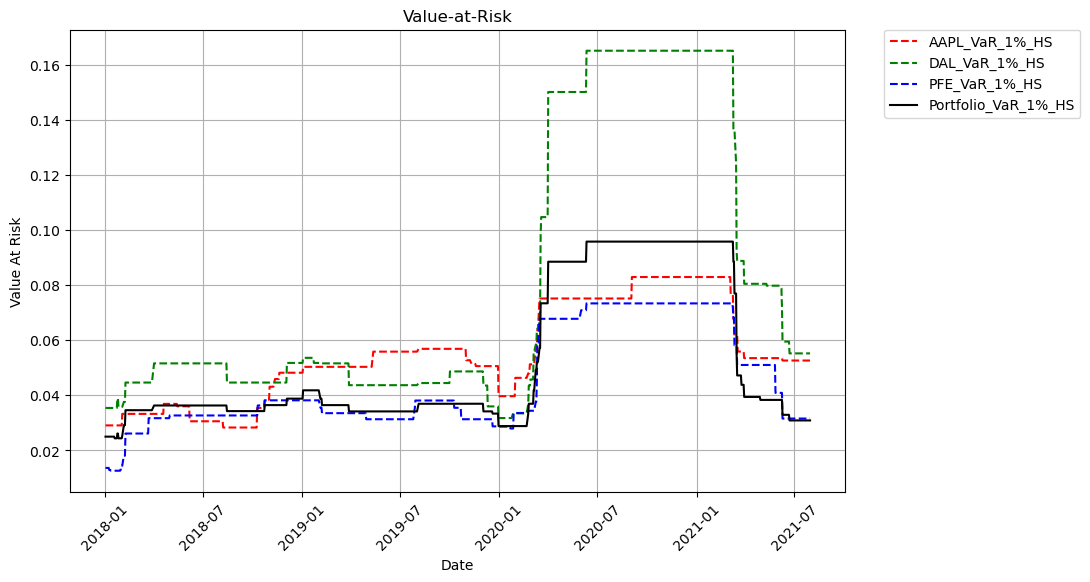

In [10]:
# Plot VaR at 1% for stocks and portfolios
plt.figure(figsize=(10,6))
plt.plot(aapl_var['Date'], -aapl_var['VaR_1%_HS'], 'r--', label='AAPL_VaR_1%_HS')
plt.plot(dal_var['Date'], -dal_var['VaR_1%_HS'], 'g--', label='DAL_VaR_1%_HS')
plt.plot(pfe_var['Date'], -pfe_var['VaR_1%_HS'], 'b--', label='PFE_VaR_1%_HS')
plt.plot(pm_var_1['Date'], -pm_var_1['VaR_1%_HS'], 'k-', label='Portfolio_VaR_1%_HS')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk')
plt.show()

According to the graph on VaR of the three stocks and the portfolio consisting of those three using Historical Simulation approach, we can reach several conclusions:

(1) The VaR calculated by HS approach changes slow and may stay at high level for some time. 

(2) The VaR of the portfolio can be smaller than any stocks it consists of.



Then plot the ES graph with the same time horizon.

In [11]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
aapl_es = aapl_es[(aapl_es['Date'] > start_date) & (aapl_es['Date'] <= end_date)]
dal_es = dal_es[(dal_es['Date'] > start_date) & (dal_es['Date'] <= end_date)]
pfe_es = pfe_es[(pfe_es['Date'] > start_date) & (pfe_es['Date'] <= end_date)]
pm_es_1 = pm_es[(pm_es['Date'] > start_date) & (pm_es['Date'] <= end_date)]

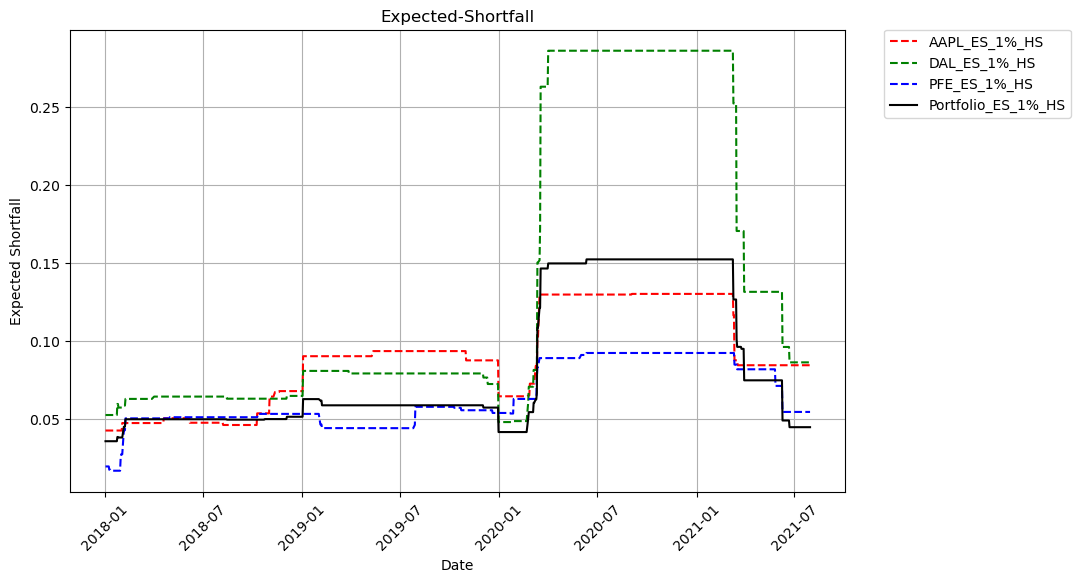

In [12]:
# Plot ES at 1% for stocks and portfolios
plt.figure(figsize=(10,6))
plt.plot(aapl_es['Date'], -aapl_es['ES_1%_HS'], 'r--', label='AAPL_ES_1%_HS')
plt.plot(dal_es['Date'], -dal_es['ES_1%_HS'], 'g--', label='DAL_ES_1%_HS')
plt.plot(pfe_es['Date'], -pfe_es['ES_1%_HS'], 'b--', label='PFE_ES_1%_HS')
plt.plot(pm_es_1['Date'], -pm_es_1['ES_1%_HS'], 'k-', label='Portfolio_ES_1%_HS')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Expected-Shortfall')
plt.show()

Now we can compare VaR with ES as follows, where solid lines stand for ES and dotted lines stand for VaR.

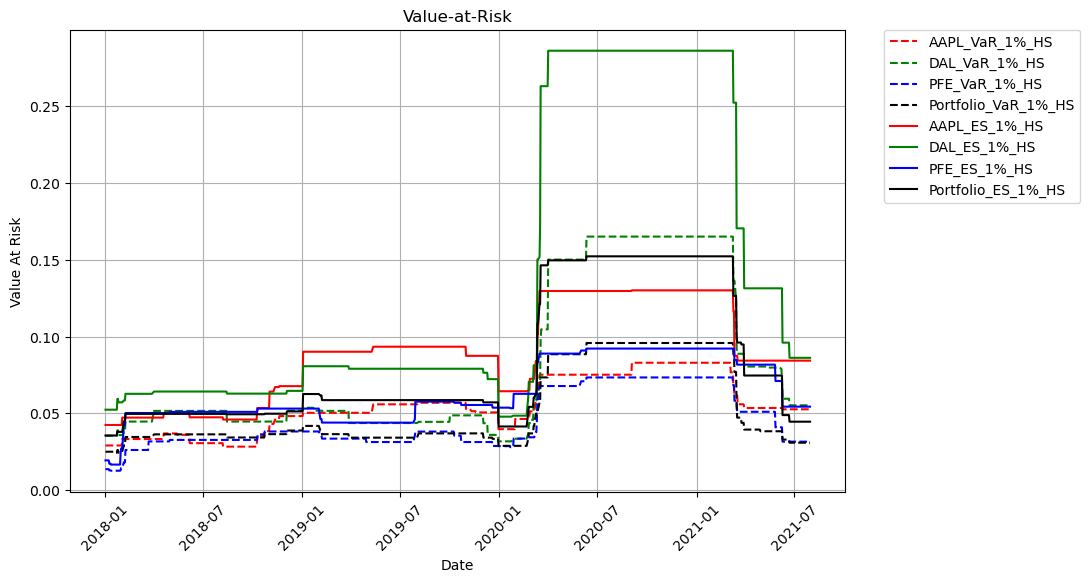

In [13]:
# Plot VaR at 1% for stocks and portfolios
plt.figure(figsize=(10,6))
plt.plot(aapl_var['Date'], -aapl_var['VaR_1%_HS'], 'r--', label='AAPL_VaR_1%_HS')
plt.plot(dal_var['Date'], -dal_var['VaR_1%_HS'], 'g--', label='DAL_VaR_1%_HS')
plt.plot(pfe_var['Date'], -pfe_var['VaR_1%_HS'], 'b--', label='PFE_VaR_1%_HS')
plt.plot(pm_var_1['Date'], -pm_var_1['VaR_1%_HS'], 'k--', label='Portfolio_VaR_1%_HS')

plt.plot(aapl_es['Date'], -aapl_es['ES_1%_HS'], 'r-', label='AAPL_ES_1%_HS')
plt.plot(dal_es['Date'], -dal_es['ES_1%_HS'], 'g-', label='DAL_ES_1%_HS')
plt.plot(pfe_es['Date'], -pfe_es['ES_1%_HS'], 'b-', label='PFE_ES_1%_HS')
plt.plot(pm_es_1['Date'], -pm_es_1['ES_1%_HS'], 'k-', label='Portfolio_ES_1%_HS')


plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value At Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk')
plt.show()

According to the graph on ES of the three stocks and the portfolio consisting of those three using Historical Simulation approach, we can reach several conclusions:

(1) Under same circumstance, ES for a certain stock/portfolio is usually larger than its VaR

(2) The ES of the portfolio can be smaller than any stocks it consists of.



## Question 2

For this question I use parametric method assuming with normal distribution.

Note that only portfolio estimation is required.

We can directly get the mean and standard error of log_return because for a normal distribution N(mu, var), its mean is mu, and standard error is sterr

In [14]:
# get the mean and standard deviation of the log_return
mu = pm_var['log_return'].mean()
sterr = pm_var['log_return'].std()

print("Mean:%s, Stdev:%s"%(mu,sterr))

Mean:0.0002422648101768074, Stdev:0.016344460390756023


We need to get the 1% cutoff point from the normal distribution

In [15]:
from scipy.stats import norm
alpha = 0.01

z_alpha = norm.ppf(0.01, loc=0, scale=1)

for i in range(0,len(pm_var)):
    # include the trading day
    history = pm_var.loc[(i-249):(i),'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        mu = history.mean()
        sterr = history.std()
        pm_var.loc[i,'VaR_1%_Param'] = mu + sterr*z_alpha
        pm_es.loc[i,'ES_1%_Param'] = mu + sterr*norm.pdf(norm.ppf(0.99,loc=0,scale=1),loc=0,scale=1)/0.01
    else:
        pm_var.loc[i,'VaR_1%_Param'] = np.NaN
        pm_es.loc[i,'ES_1%_Param'] = np.NaN

We need to plot on the period 2018-01-01 to 2021-07-31

In [16]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
pm_var_2 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]
pm_es_2 = pm_es[(pm_es['Date'] > start_date) & (pm_es['Date'] <= end_date)]

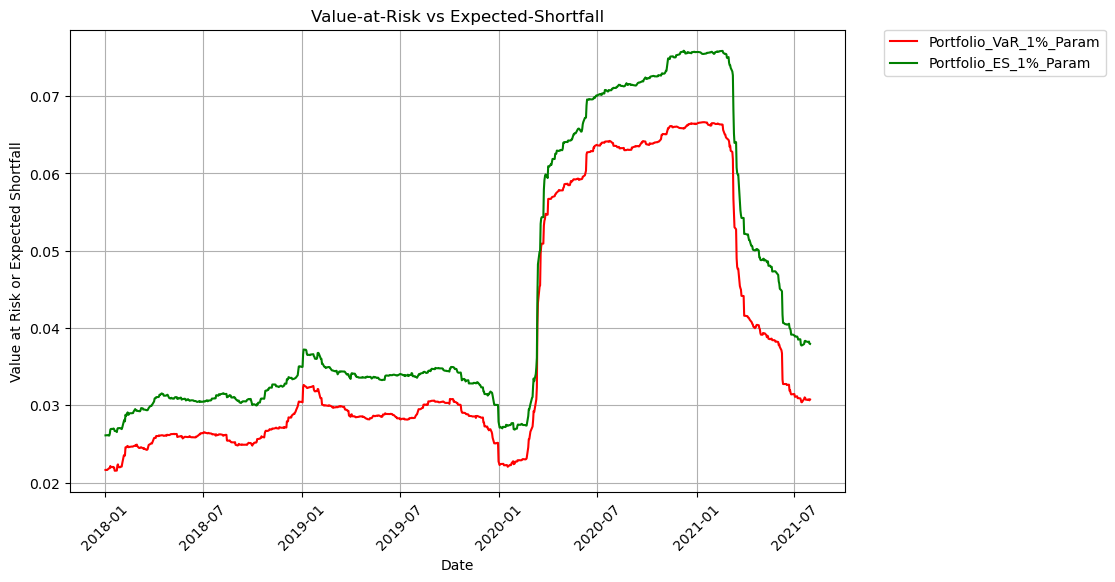

In [17]:
# Plot VaR vs ES at 1%
plt.figure(figsize=(10,6))
plt.plot(pm_var_2['Date'], -pm_var_2['VaR_1%_Param'], 'r-',label='Portfolio_VaR_1%_Param')
plt.plot(pm_es_2['Date'], pm_es_2['ES_1%_Param'], 'g-', label='Portfolio_ES_1%_Param')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk or Expected Shortfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk vs Expected-Shortfall')
plt.show()

Now according to the figure, we can find that ES is still always larger than VaR.

## Question 3

For this question we are given two tasks.

First we must estimate the two coefficients for the given equation.

In [18]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
pm_var_3 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]
pm_var_3.dropna()

,Date,PortValue,Prev_PortValue,log_return,VaR_1%_HS,VaR_1%_Param
251,2018-01-02 00:00:00-05:00,90257.444382,89243.180084,0.011301,-0.025023,-0.021627
252,2018-01-03 00:00:00-05:00,89477.212143,90257.444382,-0.008682,-0.025023,-0.021634
253,2018-01-04 00:00:00-05:00,89577.891922,89477.212143,0.001125,-0.025023,-0.021624
254,2018-01-05 00:00:00-05:00,89990.394974,89577.891922,0.004594,-0.025023,-0.021616
255,2018-01-08 00:00:00-05:00,88421.397781,89990.394974,-0.017589,-0.025023,-0.021809
...,...,...,...,...,...,...
1147,2021-07-26 00:00:00-04:00,110583.895874,109116.204834,0.013361,-0.030902,-0.030691
1148,2021-07-27 00:00:00-04:00,109707.853699,110583.895874,-0.007954,-0.030902,-0.030766
1149,2021-07-28 00:00:00-04:00,110966.353607,109707.853699,0.011406,-0.030902,-0.030686
1150,2021-07-29 00:00:00-04:00,110770.135498,110966.353607,-0.001770,-0.030902,-0.030632


We can use LinearRegression to calculate them.

In [19]:
from sklearn.linear_model import LinearRegression
import pandas as pd

log_returns = pm_var['log_return']
X = pd.concat([log_returns.shift(1),log_returns.shift(2)],axis=1).dropna()
y = log_returns.iloc[3:].dropna()

model = LinearRegression().fit(X,y)

b1 = model.coef_[0]
b2 = model.coef_[1]

print("Coefficient φ1:%s"%(b1))
print("Coefficient φ2:%s"%(b2))

Coefficient φ1:-0.025057653692734924
Coefficient φ2:0.05956315736345589


Second we apply Monte Carlo Simulation approach with 5000 samples.

We start with estimating mu.

In [20]:
z_alpha = norm.ppf(0.01, loc=0, scale=1)

for i in range(0,len(pm_var)):
    history = pm_var.loc[(i-249):(i),'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        mu = history.mean()
        sterr = history.std()
        T = 1
        new_mu = (mu-(sterr**2)/2)*T
        new_sterr = sterr*sqrt(T)
        
        # do single round
        np.random.seed(12345)
        alpha = 0.01
        N_simulations = 5000
        log_returns = np.random.normal(loc=new_mu, scale=new_sterr, size=N_simulations)
        # sort log_returns from low to high and find the cutoff rate
        log_returns = sorted(log_returns, reverse=False)
        pm_var.loc[i,'VaR_1%_MC'] = log_returns[int(N_simulations*alpha)]
    else:
        pm_var.loc[i,'VaR_1%_MC'] = np.NaN

print("New μ:%s"%(new_mu))
print("New σ:%s"%(new_sterr))


New μ:-0.0008506941231667729
New σ:0.016898269647749178


Now we can plot estimate VaR for the portfolio.

In [21]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
pm_var_3 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]

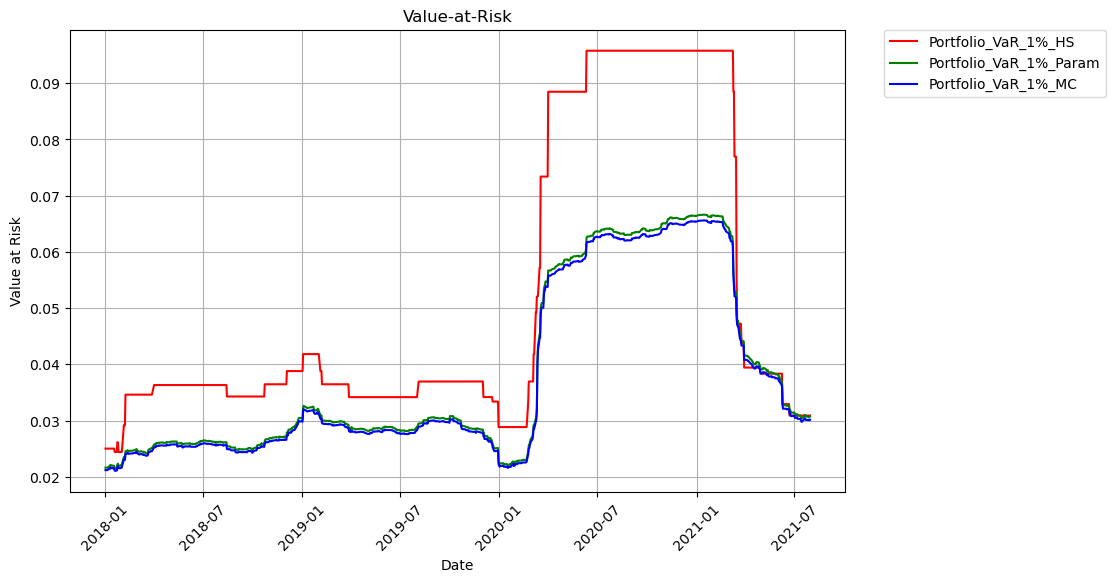

In [22]:
# Plot VaR at 1%
plt.figure(figsize=(10,6))
plt.plot(pm_var_3['Date'], -pm_var_3['VaR_1%_HS'], 'r-',label='Portfolio_VaR_1%_HS')
plt.plot(pm_var_3['Date'], -pm_var_3['VaR_1%_Param'], 'g-', label='Portfolio_VaR_1%_Param')
plt.plot(pm_var_3['Date'], -pm_var_3['VaR_1%_MC'], 'b-', label='Portfolio_VaR_1%_MC')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk')
plt.show()

## Question 4

Now we do some backtesting to validate the VaR(1%) estimation from Q2 using both unconditional test and independence test.

First we plot parametric VaR vs Returns.

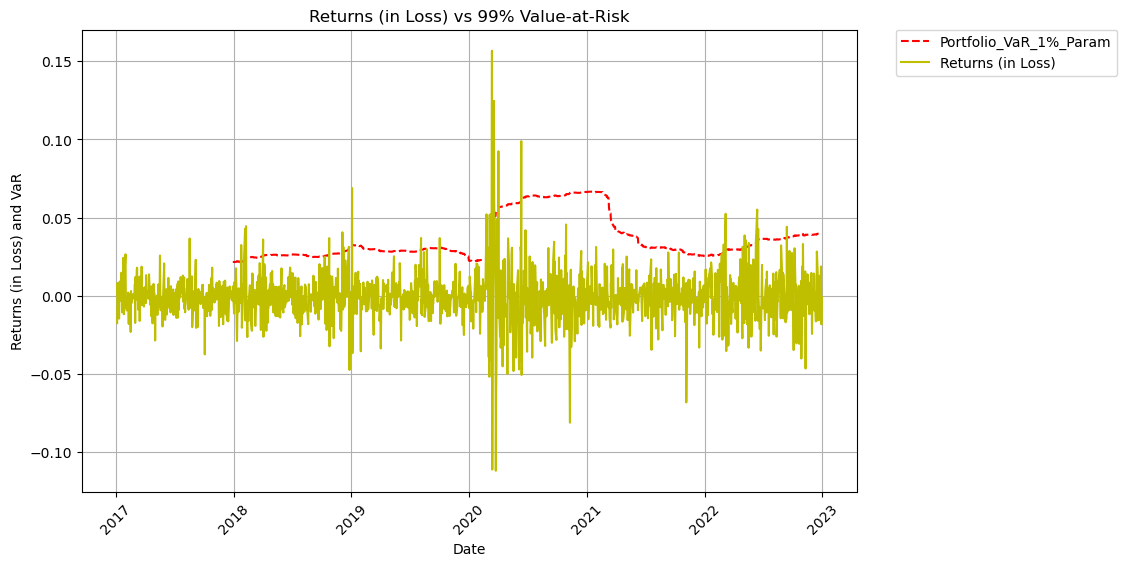

In [23]:
plt.figure(figsize=(10,6))
plt.plot(pm_var['Date'], -pm_var['VaR_1%_Param'], 'r--', label='Portfolio_VaR_1%_Param')
plt.plot(pm_var['Date'], -pm_var['log_return'], 'y-', label='Returns (in Loss)')
plt.grid(True)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 99% Value-at-Risk')
plt.show()

Then we zoom into the time horizon if 2021-08-01 to 2022-12-31

In [24]:
# Zoom in: from '2021-08-01' to '2022-12-31'
start_date = '2021-08-01'
end_date = '2022-12-31'
pm_var_4 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]

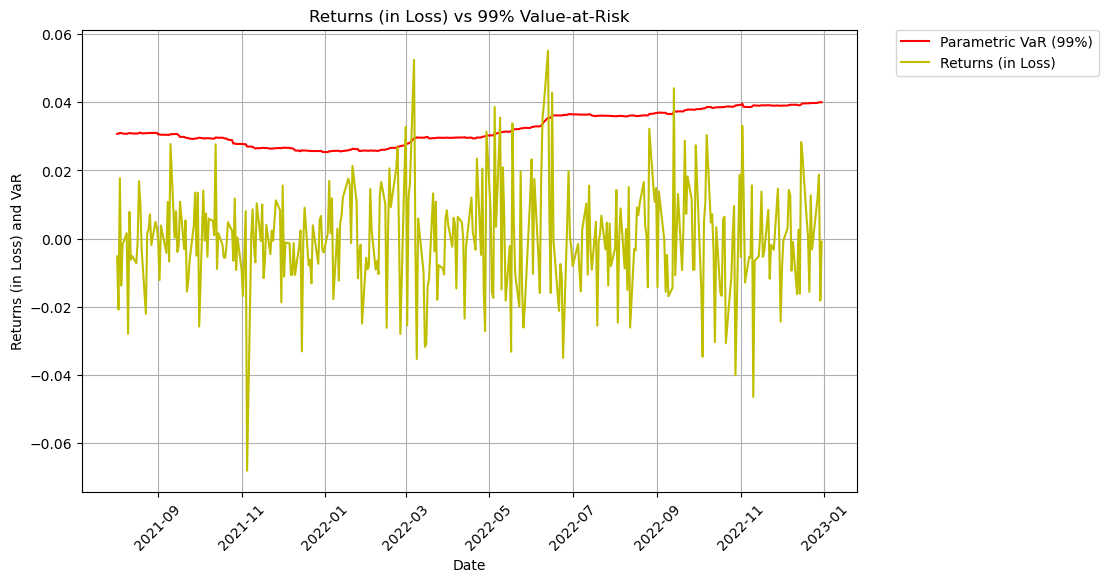

In [25]:
plt.figure(figsize=(10,6))
plt.plot(pm_var_4['Date'], -pm_var_4['VaR_1%_Param'], 'r-', label='Parametric VaR (99%)')
plt.plot(pm_var_4['Date'], -pm_var_4['log_return'], 'y-', label='Returns (in Loss)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns (in Loss) and VaR')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Returns (in Loss) vs 99% Value-at-Risk')
plt.show()

A VaR failure or violation happens when the VaR is exceeded by negative return (i.e., loss). 

Select and Zoom in on dates with exceptions.

In [26]:
exception_param_date = pm_var[pm_var['VaR_1%_Param']>pm_var['log_return']]['Date']

exception_param = pm_var[pm_var['Date'].isin(exception_param_date)]

Then we do statistical tests for VaR backtesting

In [27]:
observed_level = 1 - len(pm_var[pm_var['VaR_1%_Param']>pm_var['log_return']])/len(pm_var)
observations = len(pm_var)
failures = len(pm_var[pm_var['VaR_1%_Param']>pm_var['log_return']])
expected = observations*0.01

print("Parametric VaR 1%") 
print("VaR level: %s" %(0.99))
print("Observed level: %s" %(observed_level))
print("Observations: %s" %(observations))
print("Failures: %s" %(failures)) 
print("Expected: %s" %(expected))

Parametric VaR 1%
VaR level: 0.99
Observed level: 0.976158940397351
Observations: 1510
Failures: 36
Expected: 15.1


Then we can use equations to get p value of 99% VaR as Bernoulli Test for VaR models

In [28]:
from scipy.stats import binom

observed_level = 1 - len(pm_var[pm_var['VaR_1%_Param']>pm_var['log_return']])/len(pm_var)
observations = len(pm_var)
failures = len(pm_var[pm_var['VaR_1%_Param']>pm_var['log_return']])
expected = observations*0.01
ratio = failures/expected
backtesting_alpha = 0.05 #backtesting confidence interval
p_value_99 = 1-binom.cdf(failures, observations, 0.01)
print("P-value of Parametric VaR 95%: ", p_value_99)
if(p_value_99 < backtesting_alpha):
    print("Reject null hypothesis")
else:
    print(f"Not enough evidence to reject null at {backtesting_alpha} backtesting significance level under binomial distribution")

P-value of Parametric VaR 95%:  1.181297708430229e-06
Reject null hypothesis


For Independence test of VaR  99%, we can do as follows.

ind_t: indicate whether exception at t<br>
ind_t1: indicate whether exception at t-1<br>

'ind_00' — indicate periods with no failures followed by a period with no failures<br>
'ind_10' — indicate periods with failures followed by a period with no failures<br>
'ind_01' — indicate periods with no failures followed by a period with failures<br>
'ind_11' — indicate periods with failures followed by a period with failures<br>

'N00' — Number of periods with no failures followed by a period with no failures<br>
'N10' — Number of periods with failures followed by a period with no failures<br>
'N01' — Number of periods with no failures followed by a period with failures<br>
'N11' — Number of periods with failures followed by a period with failures<br>

p01 = Probability of having a failure on period t, given that there was no failure on period t–1<br>
p11 = Probability of having a failure on period t, given that there was a failure on period t–1<br>
hat_p = Probability of having a failure on period t<br>

In [29]:
from copy import deepcopy
df_99 = deepcopy(pm_var)

df_99['ind_t'] = df_99.apply(lambda row: 1 if row['VaR_1%_Param']>row['log_return'] else 0, axis=1)
df_99['ind_t1'] = df_99['ind_t'].shift(1)

df_99['ind_00'] = df_99.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==0 else 0, axis=1)
df_99['ind_10'] = df_99.apply(lambda row: 1 if row['ind_t']==0 and row['ind_t1']==1 else 0, axis=1)
df_99['ind_01'] = df_99.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==0 else 0, axis=1)
df_99['ind_11'] = df_99.apply(lambda row: 1 if row['ind_t']==1 and row['ind_t1']==1 else 0, axis=1)

# Drop missing values
df_99.dropna(inplace=True)

N00, N10, N01, N11 = df_99[['ind_00','ind_10','ind_01','ind_11']].sum(axis=0)

p_01 = N01/(N00+N01)
p_11 = N11/(N10+N11)
hat_p = (N01+N11)/(N00+N01+N10+N11)

z= (p_11-p_01)/(np.sqrt(hat_p*(1-hat_p)*((1/(N01+N11))+(1/(N00+N10)))))
print('p_11='+str(round(p_11,3))+', p_01='+str(round(p_01,3))+', Z='+str(z))

p_11=0.194, p_01=0.024, Z=6.061081738567744


Z is large enough for us to reject H0

In conclusion, by applying both unconditional test and independence test, we can reject H0 and the VaR estimation cannot be validated under the assumption of normal distribution.

## Question 5

Now we can surely say that normal distribution isn't suitable for parameterizing log returns.

Another assumption is made that the log returns actually follows a Lévy alpha-stable distribution and we are to estimate the stability parameter and the skewness parameter with loc=0 and scale=1.

We use the time horizon from 2018-01-01 to 2021-07-31

In [30]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
pm_var_5 = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]
pm_var_5.dropna()

,Date,PortValue,Prev_PortValue,log_return,VaR_1%_HS,VaR_1%_Param,VaR_1%_MC
251,2018-01-02 00:00:00-05:00,90257.444382,89243.180084,0.011301,-0.025023,-0.021627,-0.021194
252,2018-01-03 00:00:00-05:00,89477.212143,90257.444382,-0.008682,-0.025023,-0.021634,-0.021201
253,2018-01-04 00:00:00-05:00,89577.891922,89477.212143,0.001125,-0.025023,-0.021624,-0.021191
254,2018-01-05 00:00:00-05:00,89990.394974,89577.891922,0.004594,-0.025023,-0.021616,-0.021183
255,2018-01-08 00:00:00-05:00,88421.397781,89990.394974,-0.017589,-0.025023,-0.021809,-0.021375
...,...,...,...,...,...,...,...
1147,2021-07-26 00:00:00-04:00,110583.895874,109116.204834,0.013361,-0.030902,-0.030691,-0.030095
1148,2021-07-27 00:00:00-04:00,109707.853699,110583.895874,-0.007954,-0.030902,-0.030766,-0.030171
1149,2021-07-28 00:00:00-04:00,110966.353607,109707.853699,0.011406,-0.030902,-0.030686,-0.030090
1150,2021-07-29 00:00:00-04:00,110770.135498,110966.353607,-0.001770,-0.030902,-0.030632,-0.030039


I use the levy_stable.fit() to get the parameters.

In [31]:
import numpy as np
from scipy.stats import levy_stable

# extract log returns from pm_var dataset
log_returns = pm_var_5['log_return'].values

# actual log returns, as given formula
actual_returns = 120*(log_returns + 0.005)

# estimate parameters using scipy.stats.levy_stable.fit function
params = levy_stable.fit(actual_returns, loc=0, scale=1)

# extract stability parameter alpha and skewness parameter beta from params
alpha, beta = params[0], params[1]

# print estimated parameters

print(f"Stability parameter alpha: {alpha}")
print(f"Skewness parameter beta: {beta}")

Stability parameter alpha: 1.2521115430898808
Skewness parameter beta: -0.3805027178697813


Then we calculate the values of VaR(1%) for the portfolio.

In [37]:
from scipy.stats import norm

z_alpha = levy_stable.ppf(0.01,alpha, beta, loc=0, scale=1)

for i in range(0,len(pm_var)):
    history = pm_var.loc[(i-249):(i),'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        mu = history.mean()
        sterr = history.std()
        pm_var.loc[i,'VaR_1%_Levy'] = mu + sterr*z_alpha
    else:
        pm_var.loc[i,'VaR_1%_Levy'] = np.NaN

The values of VaR(5%) can be calculated similarly.

In [38]:
from scipy.stats import norm

z_alpha = levy_stable.ppf(0.05,alpha, beta, loc=0, scale=1)

for i in range(0,len(pm_var)):
    history = pm_var.loc[(i-249):(i),'log_return']
    history.dropna(inplace=True)
    if len(history)==250:
        mu = history.mean()
        sterr = history.std()
        pm_var.loc[i,'VaR_5%_Levy'] = mu + sterr*z_alpha
    else:
        pm_var.loc[i,'VaR_5%_Levy'] = np.NaN

In [39]:
# Zoom in: from '2018-01-01' to '2021-07-31'
start_date = '2018-01-01'
end_date = '2021-07-31'
pm_var_levy = pm_var[(pm_var['Date'] > start_date) & (pm_var['Date'] <= end_date)]

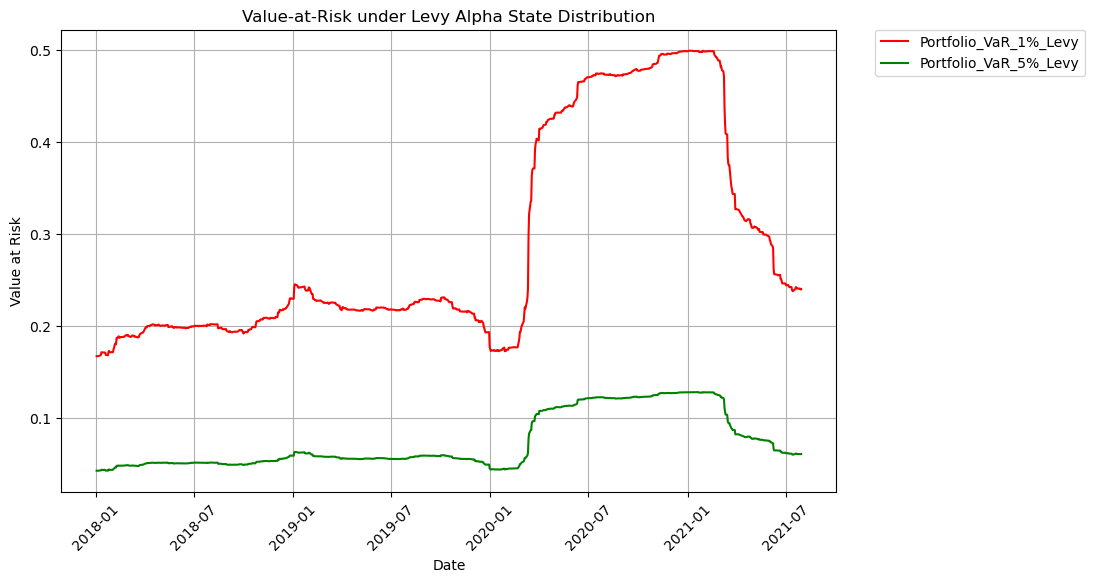

In [41]:
# Plot VaR vs ES at 1%
plt.figure(figsize=(10,6))
plt.plot(pm_var_levy['Date'], -pm_var_levy['VaR_1%_Levy'], 'r-',label='Portfolio_VaR_1%_Levy')
plt.plot(pm_var_levy['Date'], -pm_var_levy['VaR_5%_Levy'], 'g-',label='Portfolio_VaR_5%_Levy')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Value-at-Risk under Le')
plt.show()